In [1]:
import pandas as pd
import numpy as np
import os
import sys
import math
import json
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import matplotlib.patches as patches
from IPython.display import Markdown

In [97]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
parent_dir = os.path.abspath(os.path.join(os.path.dirname("./"), '..'))
sys.path.append(parent_dir)
from tools.lineup_tpr import LineupTPR
from tools.pickler import Save_Model, Load_Model
from tools.draw_pitch_plot import Draw_Pitch_Actions
from tools.fm_attributes import Attributes
fm_attributes = Attributes.attribute_list
gk_attributes = Attributes.gk_attributes

In [4]:
players_df = pd.read_csv("../players_db/fm23/fm23db_processed.csv")
team_df = pd.read_csv("../players_db/fm23/team_ratings.csv")

<br><br><br><br><br><br><br><br>
<h2 style="color:beige;background:gray;"><b style="color:beige;background:red;">Attack</b> Data Prep - for Action Player "Volume" Regression</h2>

<br><br>
<h3 style="color:yellow;background:pink;">  Passing</h3>

In [5]:
# url = "https://fbref.com/en/comps/Big5/2022-2023/passing/players/2022-2023-Big-5-European-Leagues-Stats"
# dataPASSING = pd.read_html(url)
# dataPASSING[0].to_csv("data/Big5@Players@Passing@2022_2023.csv",index=False)
# # Att, Att, Att -> same column names occurs
# fb = dataPASSING[0]
# #fb.columns
# fb['90s'] = pd.to_numeric(fb[('Unnamed: 8_level_0','90s')], errors='coerce')
# fb['Att'] = pd.to_numeric(fb[('Total','Att')], errors='coerce')
# fb['Pos'] = fb[('Unnamed: 3_level_0','Pos')]
# fb['Squad'] = fb[('Unnamed: 4_level_0','Squad')]
# fb['Player'] = fb[('Unnamed: 1_level_0','Player')]
# fb['Pass/90'] = fb['Att'] / fb['90s']
# fb2 = fb[fb["90s"] > 15]
# fb2.columns = fb2.columns.get_level_values(0)
# fb2.sort_values(by="Pass/90", ascending=False).head(3)[["Pos","Squad","Player","Att","Pass/90"]]

In [6]:
fb2_raw = pd.read_csv("data/Big5@Players@Passing@2022_2023.csv")
fb2 = fb2_raw[fb2_raw["90s"] > 15]
fb_passing = fb2.sort_values(by="Pass/90", ascending=False)[["Pos","Squad","Player","Att","Pass/90"]]
#fb_passing["Pos"] = fb_passing["Pos"].apply(lambda row: row.split(",")[0])
pass_merged_df = pd.merge(players_df, fb_passing, how="inner", left_on="Name", right_on="Player", suffixes=("","_fb"))

In [7]:
passing_positions = pass_merged_df.sort_values(by="Pass/90", ascending=False).head(50)["Pos_Rank_Average"]
print(passing_positions.mean())
passing_ratings = pass_merged_df.sort_values(by="Pass/90", ascending=False).head(50)[fm_attributes].mean().sort_values(ascending=False)

4.24


<br><br>
<h3 style="color:beige;background:red;">  Shooting</h3>

In [8]:
# url = "https://fbref.com/en/comps/Big5/2022-2023/shooting/players/2022-2023-Big-5-European-Leagues-Stats"
# dataSHOOTING = pd.read_html(url)
# dataSHOOTING[0].to_csv("data/Big5@Players@Shooting@2022_2023.csv",index=False)
# dataSHOOTING[0].columns = dataSHOOTING[0].columns.get_level_values(1)
# fb = dataSHOOTING[0]
# fb.columns
# fb['90s'] = pd.to_numeric(fb['90s'], errors='coerce')
# fb['Sh'] = pd.to_numeric(fb['Sh'], errors='coerce')
# fb['Sh/90'] = pd.to_numeric(fb['Sh/90'], errors='coerce')
# fb2 = fb[fb["90s"] > 15]
# fb2.sort_values(by="Sh/90", ascending=False).head(3)[["Pos","Squad","Player","Sh","Sh/90"]]

In [9]:
fb2_raw = pd.read_csv("data/Big5@Players@Shooting@2022_2023.csv")
fb2 = fb2_raw[fb2_raw["90s"] > 15]
fb_shooters = fb2.sort_values(by="Sh/90", ascending=False)[["Pos","Squad","Player","Sh","Sh/90"]]
fb_shooters["Pos"] = fb_shooters["Pos"].apply(lambda row: row.split(",")[0])
sh_merged_df_raw = pd.merge(players_df, fb_shooters, how="inner", left_on="Name", right_on="Player", suffixes=("","_fb"))
sh_merged_df = sh_merged_df_raw[sh_merged_df_raw["Best_Pos"] != "GK"]

In [10]:
shooters_positions = sh_merged_df.sort_values(by="Sh/90", ascending=False).head(50)["Pos_Rank_Average"]
print(shooters_positions.mean())
shooters_ratings = sh_merged_df.sort_values(by="Sh/90", ascending=False).head(50)[fm_attributes].mean().sort_values(ascending=False)

11.3


<br><br>
<h3 style="color:red;background:orange;">  Dribbling</h3>

In [11]:
# url = "https://fbref.com/en/comps/Big5/2022-2023/possession/players/2022-2023-Big-5-European-Leagues-Stats"
# dataDRIBBLING = pd.read_html(url)
# dataDRIBBLING[0].to_csv("data/Big5@Players@Dribbling@2022_2023.csv",index=False)
# fb = dataDRIBBLING[0]
# #fb.columns
# fb['90s'] = pd.to_numeric(fb[('Unnamed: 8_level_0','90s')], errors='coerce')
# fb['Att'] = pd.to_numeric(fb[('Take-Ons','Att')], errors='coerce')
# fb['Pos'] = fb[('Unnamed: 3_level_0','Pos')]
# fb['Squad'] = fb[('Unnamed: 4_level_0','Squad')]
# fb['Player'] = fb[('Unnamed: 1_level_0','Player')]
# fb['Dribble/90'] = fb['Att'] / fb['90s']
# fb2 = fb[fb["90s"] > 15]
# fb2.columns = fb2.columns.get_level_values(0)
# fb2.sort_values(by="Dribble/90", ascending=False).head(3)[["Pos","Squad","Player","Att","Dribble/90"]]

In [12]:
fb2_raw = pd.read_csv("data/Big5@Players@Dribbling@2022_2023.csv")
fb2 = fb2_raw[fb2_raw["90s"] > 15]
fb_dribbling = fb2.sort_values(by="Dribble/90", ascending=False)[["Pos","Squad","Player","Att","Dribble/90"]]
#fb_dribbling["Pos"] = fb_dribbling["Pos"].apply(lambda row: row.split(",")[0])
dribble_merged_df = pd.merge(players_df, fb_dribbling, how="inner", left_on="Name", right_on="Player", suffixes=("","_fb"))

In [13]:
dribbling_positions = dribble_merged_df.sort_values(by="Dribble/90", ascending=False).head(50)["Pos_Rank_Average"]
print(dribbling_positions.mean())
dribbling_ratings= dribble_merged_df.sort_values(by="Dribble/90", ascending=False).head(50)[fm_attributes].mean().sort_values(ascending=False)

9.92


In [14]:
# pass_merged_df, sh_merged_df, dribble_merged_df

In [15]:
# passing_top_cols, shooting_top_cols, dribbling_top_cols

In [16]:
top_N = 12

In [17]:
shooting_top_cols = shooters_ratings[:top_N].index
shooting_top_cols

Index(['Off_the_Ball', 'Technique', 'Flair', 'Pace', 'Acceleration',
       'First_Touch', 'Finishing', 'Agility', 'Determination', 'Dribbling',
       'Anticipation', 'Natural_Fitness'],
      dtype='object')

In [18]:
passing_top_cols = passing_ratings[:top_N].index
passing_top_cols

Index(['Determination', 'Anticipation', 'Teamwork', 'Stamina', 'Composure',
       'Natural_Fitness', 'Passing', 'Work_Rate', 'Tackling', 'Decisions',
       'First_Touch', 'Technique'],
      dtype='object')

In [19]:
dribbling_top_cols = dribbling_ratings[:top_N].index
dribbling_top_cols

Index(['Dribbling', 'Acceleration', 'Flair', 'Pace', 'Technique', 'Agility',
       'First_Touch', 'Determination', 'Natural_Fitness', 'Off_the_Ball',
       'Passing', 'Vision'],
      dtype='object')

<br><br><br><br><br><br><br><br>
<h2 style="color:pink;background:purple;"><b style="color:beige;background:red;">Attack</b> Data Prep - for Action Player "Accuracy"
Regression</h2>

<br><br><br><br><br><br><br><br>
<h2 style="color:beige;background:gray;"><b style="color:beige;background:red;">Attack</b> Data Prep - for Action Player "Accuracy" Regression</h2>

<br>
<h3 style="color:black;background:white;">  Passing</h3>

In [20]:
# fb2_raw = pd.read_csv("data/Big5@Players@Passing@2022_2023.csv")
# fb2_raw["Pass_Accuracy"] = pd.to_numeric(fb2_raw["Total.2"], errors="coerce")
# fb2_raw.to_csv("data/Big5@Players@Passing@2022_2023.csv", index=False)

In [21]:
fb2_raw = pd.read_csv("data/Big5@Players@Passing@2022_2023.csv")
fb2_raw = fb2_raw[fb2_raw["Pos"] != "I WANT GK"]
fb2_raw["Att"] = pd.to_numeric(fb2_raw["Att"], errors="coerce")
filter_value = fb2_raw["Att"].max() / 10
print(filter_value)

322.3


In [22]:
fb2 = fb2_raw[fb2_raw["Att"] > filter_value]
fb2["Pass_Accuracy"] = pd.to_numeric(fb2["Total.2"])
fb_passing_acc = fb2.sort_values(by="Pass_Accuracy", ascending=False)[["Pos","Squad","Player","Pass_Accuracy","Att"]]
#fb_passing_acc["Pos"] = fb_passing_acc["Pos"].apply(lambda row: row.split(",")[0])
pass_merged_df = pd.merge(players_df, fb_passing_acc, how="inner", left_on="Name", right_on="Player", suffixes=("","_fb"))

In [23]:
passing_positions = pass_merged_df.sort_values(by="Pass_Accuracy", ascending=False).head(50)["Pos_Rank_Average"]
print(passing_positions.mean())
passing_ratings = pass_merged_df.sort_values(by="Pass_Accuracy", ascending=False).head(50)[fm_attributes].mean().sort_values(ascending=False)

4.54


<br>
<h3 style="color:black;background:white;">  Shooting</h3>

In [24]:
# fb2_raw = pd.read_csv("data/Big5@Players@Shooting@2022_2023.csv")
# fb2_raw["Shot_Accuracy"] = pd.to_numeric(fb2_raw["SoT%"], errors="coerce")
# fb2_raw.to_csv("data/Big5@Players@Shooting@2022_2023.csv", index=False)

In [25]:
fb2_raw = pd.read_csv("data/Big5@Players@Shooting@2022_2023.csv")
fb2_raw = fb2_raw[fb2_raw["Pos"] != "GK"]
fb2_raw["Sh"] = pd.to_numeric(fb2_raw["Sh"], errors="coerce")
filter_value = fb2_raw["Sh"].max() / 4
print(filter_value)

36.0


In [26]:
fb2 = fb2_raw[fb2_raw["Sh"] > filter_value]
fb2["Shot_Accuracy"] = pd.to_numeric(fb2["SoT%"])
fb2.to_csv("data/Big5@Players@Shooting@2022_2023.csv", index=False)
fb_shooting_acc = fb2.sort_values(by="Shot_Accuracy", ascending=False)[["Pos","Squad","Player","Shot_Accuracy","Sh"]]
#fb_shooting_acc["Pos"] = fb_shooting_acc["Pos"].apply(lambda row: row.split(",")[0])
sh_merged_df = pd.merge(players_df, fb_shooting_acc, how="inner", left_on="Name", right_on="Player", suffixes=("","_fb"))

In [27]:
shooters_positions = sh_merged_df.sort_values(by="Shot_Accuracy", ascending=False).head(50)["Pos_Rank_Average"]
print(shooters_positions.mean())
shooters_ratings = sh_merged_df.sort_values(by="Shot_Accuracy", ascending=False).head(50)[fm_attributes].mean().sort_values(ascending=False)

10.62


<br>
<h3 style="color:black;background:white;">  Dribbling</h3>

In [28]:
# fb2_raw = pd.read_csv("data/Big5@Players@Dribbling@2022_2023.csv")
# fb2_raw["Dribble_Accuracy"] = pd.to_numeric(fb2_raw["Take-Ons.2"], errors="coerce")
# fb2_raw.to_csv("data/Big5@Players@Dribbling@2022_2023.csv", index=False)

In [29]:
fb2_raw = pd.read_csv("data/Big5@Players@Dribbling@2022_2023.csv")
fb2_raw = fb2_raw[fb2_raw["Pos"] != "GK"]
fb2_raw["Take-Ons"] = pd.to_numeric(fb2_raw["Take-Ons"], errors="coerce")
filter_value = fb2_raw["Take-Ons"].max() / 3
print(filter_value)

102.0


In [30]:
fb2 = fb2_raw[fb2_raw["Take-Ons"] > filter_value].dropna()
fb2["Dribble_Accuracy"] = pd.to_numeric(fb2["Take-Ons.2"])
fb_dribbling_acc = fb2.sort_values(by="Dribble_Accuracy", ascending=False)[["Pos","Squad","Player","Dribble_Accuracy","Take-Ons"]]
#fb_dribbling_acc["Pos"] = fb_dribbling_acc["Pos"].apply(lambda row: row.split(",")[0])
dribble_merged_df = pd.merge(players_df, fb_dribbling_acc, how="inner", left_on="Name", right_on="Player", suffixes=("","_fb"))

In [31]:
dribbling_positions = dribble_merged_df.sort_values(by="Dribble_Accuracy", ascending=False).head(50)["Pos_Rank_Average"]
print(dribbling_positions.mean())
dribbling_ratings= dribble_merged_df.sort_values(by="Dribble_Accuracy", ascending=False).head(50)[fm_attributes].mean().sort_values(ascending=False)

9.5


<br><br><br><br><br><br><br><br>
<h2 style="color:lightgreen;background:blue;"><b style="color:beige;background:red;">Attack</b> Action Player Volume & Accuracy Regression</h2>

In [32]:
def Prepare_Action_Player_Volume_Accuracy_Regression_Data(players_df, csv_file, filter_column, filter_value, target_variable, target_volume=None, top_playersN=None, top_colsN=None, fm_attributes=None, gk_excluded=None):
    fb2_raw = pd.read_csv(csv_file)
    fb2_raw[filter_column] = pd.to_numeric(fb2_raw[filter_column], errors="coerce")
    fb2 = fb2_raw[fb2_raw[filter_column] > filter_value]
    
    if target_volume:
        fb_actions = fb2.sort_values(by=target_variable, ascending=False)[["Pos","Squad","Player",target_volume,target_variable]]
    else:
        fb_actions = fb2.sort_values(by=target_variable, ascending=False)[["Pos","Squad","Player",target_volume,target_variable]]
        
    fb_actions["Pos"] = fb_actions["Pos"].apply(lambda row: row.split(",")[0])
    merged_df_raw = pd.merge(players_df, fb_actions, how="inner", left_on="Name", right_on="Player", suffixes=("","_fb"))
    
    if gk_excluded:
        merged_df = merged_df_raw[merged_df_raw["Best_Pos"] != "GK"]
    else:
        merged_df = merged_df_raw
        
    top_players = merged_df.sort_values(by=target_variable, ascending=False).head(top_playersN)
    position_mean = top_players["Pos_Rank_Average"].mean()
    top_attributes = top_players[fm_attributes].mean().sort_values(ascending=False).head(top_colsN).index
    
    return {
        "zero": 0,
        "target": target_variable,
        "raw_df": fb2_raw,
        "df": merged_df,
        "position_mean": position_mean,
        "top_playersN": top_playersN,
        "reg_cols": np.concatenate((top_attributes, ["Pos_Rank_Average"], ["tpr","tpr_club"])),
    }

In [33]:
from tools.pickler import Save_Model, Load_Model
#Save_Model("_", "models/XXXXXXXXXX_per_90_model", model)

def Train_Model(df, reg_cols, target, test_size):
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression 
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    X = df[reg_cols]
    y = df[target].astype(float)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_raw = model.predict(X_test)
    y_pred = [max(0, pred) for pred in y_pred_raw]
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        "model": model,
        "mse": mse,
        "mae": mae,
        "r2": r2
    }

In [34]:
def DictToPredictionDict(d: dict) -> pd.DataFrame:
    rdict = {}
    for k,v in d.items():
        rdict[k] = [v]
    return pd.DataFrame(rdict)

def PlayerPredict(model, current_df, current_target, reg_cols, player_name, print_stats=False):
    d0 = current_df.query(f"Name == '{player_name}'").iloc[0]
    d1 = d0[reg_cols].to_dict()
    d2 = DictToPredictionDict(d1)
    
    print(f"Name:\t\t{d0['Name']}")
    print(f"Pos_Rank_Avg:\t{d0['Pos_Rank_Average']}")
    if print_stats:
        print(f"Real:\t\t{d0[current_target]}")
    prediction = max(0, model.predict(d2)[0])
    print(f"Prediction:\t[{prediction}]")
    return prediction
    #PlayerPredict(model, current_df, chosen_dict["target"], chosen_dict["reg_cols"], "Kevin De Bruyne", print_stats=True)

def Model_Predict(model, row, cols):
    d1 = row[cols].to_dict()
    d2 = DictToPredictionDict(d1)
    prediction = max(0, model.predict(d2)[0])
    return float(round(prediction, 2))

<br><br>

<br><br><br><br><br><br><br><br>
<h2 style="color:aqua;background:yellow;">  Creating Models</h2>

In [35]:
def Create_Action_Model(action_title, team_df):
    # action_title = "Shooting_Volume"
    hyper_df = pd.read_excel("data/player_action_hyper.xlsx")
    title_df = hyper_df[hyper_df["Title"]==action_title].iloc[0]
    
    prep_by = Prepare_Action_Player_Volume_Accuracy_Regression_Data(
        players_df,
        csv_file="data/"+title_df["csv_file"],
        filter_column=title_df["filter_column"],
        filter_value=title_df["filter_value"],
        target_variable=title_df["target_variable"],
        target_volume=title_df["target_volume"],
        top_playersN=title_df["top_playersN"],
        top_colsN=title_df["top_colsN"],
        fm_attributes=fm_attributes,
        gk_excluded=title_df["gk_excluded"]
    )
    
    chosen_dict = {
        "df": prep_by["df"],
        "raw_df": prep_by["raw_df"],
        "reg_cols": prep_by["reg_cols"],
        "target": prep_by["target"],
        "test_size": title_df["test_size"],
    }
    
    current_df = pd.merge(team_df, chosen_dict["df"], how="inner", left_on="fbref_name", right_on="Squad", suffixes=("_club",""))
    model = Train_Model(current_df, chosen_dict["reg_cols"], chosen_dict["target"], chosen_dict["test_size"])["model"]
    return {
        "hyperparam_info_file": hyper_df,
        "prep_data": prep_by,
        "model": model,
        "chosen_dict": chosen_dict,
        "train_cols": chosen_dict["reg_cols"]
    }

In [36]:
# hyper_df = pd.read_excel("data/player_action_hyper.xlsx")
# players_df = pd.read_csv("../players_db/fm23/fm23db_processed.csv")
# team_df = pd.read_csv("../players_db/fm23/team_ratings.csv")

# all_df = pd.merge(team_df, players_df, how="inner", left_on="Club", right_on="Club", suffixes=("_club",""))
# for title in hyper_df["Title"]:
#     model = Create_Action_Model(title, team_df)["model"]
#     # Save_Model("_", f"./models/{title}_model", model)
#     # all_df[title] = all_df.apply(lambda row: Model_Predict(model, row, model.feature_names_in_), axis=1)
#     # predicted_df = all_df[[title,"tpr_club","UID"]]

# output_cols = np.concatenate((players_df.columns, hyper_df["Title"].tolist(), ["tpr_club"]))
# all_df.loc[all_df['Best_Pos'] == 'GK', 'shot_Volume'] = 0
# all_df.loc[all_df['Best_Pos'] == 'GK', 'dribble_Volume'] = 0
# # all_df[output_cols].to_csv("../players_db/fm23/fm23db_processed_with_futsim_triple_models.csv", index=False)

# predicted_cols = hyper_df["Title"].tolist()
# test_team = LineupTPR(all_df, "Manchester City")[["Club","Name","Playing_Position","Pos_Rank_Average"] + predicted_cols] \
# .sort_values("Pos_Rank_Average", ascending=False)
# test_team["Shot_Weight_Prob"] = test_team["shot_Volume"] / test_team["shot_Volume"].sum()

<br><br><br><br><br><br><br><br>
<h2 style="color:aqua;background:purple;">  Predictoria</h2>

In [37]:
predicted_df = pd.read_csv("../players_db/fm23/fm23db_processed_with_futsim_triple_models.csv")
location_df = pd.read_csv("data/location_df.csv")
volume_formula_df = pd.read_csv("formulas/Attacking_Touches_volume_formula_df_hyper.csv", index_col=0) # Attacking_Touches
touches_triple_prob_df = pd.read_csv("data/touches_triple_prob.csv")
touches_triple_prob_df["Triple_Prob_Dict"] = touches_triple_prob_df.Triple_Prob_Dict.apply(ast.literal_eval)

In [38]:
pass_positional_location_df = pd.read_csv("../statsbomb/data/position_included_location_384_squared_ligue1_Pass.csv").query("position!='ALL'")
shot_positional_location_df = pd.read_csv("../statsbomb/data/position_included_location_384_squared_ligue1_Shot.csv").query("position!='ALL'")
dribble_positional_location_df = pd.read_csv("../statsbomb/data/position_included_location_384_squared_ligue1_Dribble.csv").query("position!='ALL'")
positional_location_df = {
    "Pass":pass_positional_location_df,
    "Shot":shot_positional_location_df,
    "Dribble":dribble_positional_location_df,
}

In [39]:
touches_df_raw_1 = pd.read_csv("../match_logs/Big5@22-23@attacking_touches.csv")
touches_df_raw_2 = pd.merge(touches_df_raw_1, team_df, left_on="Club", right_on="Club", how="inner") 
touches_df = pd.merge(touches_df_raw_2, team_df, left_on="Opponent", right_on="fbref_name", how="inner").dropna()

<br><br><br><br>
### f()

In [40]:
fm_managerial_tactics = {
    'Standard': {"Pass": 1.0, "Shot": 1.0, "Dribble": 1.0},
    'Gegen - Direct': {"Pass": 1.2, "Shot": 1.0, "Dribble": 0.8},
    'Gegen - High Tempo': {"Pass": 1.1, "Shot": 1.1, "Dribble": 0.9},
    'Gegen - Slow Passing': {"Pass": 0.9, "Shot": 1.0, "Dribble": 1.0},
    'Gegen - Wing Play': {"Pass": 1.3, "Shot": 1.0, "Dribble": 0.7},
    
    'Tiki Taka - Direct': {"Pass": 1.5, "Shot": 0.8, "Dribble": 0.8},
    'Tiki Taka - High Tempo': {"Pass": 1.4, "Shot": 0.9, "Dribble": 0.8},
    'Tiki Taka - Slow Passing': {"Pass": 1.6, "Shot": 0.7, "Dribble": 0.9},
    'Tiki Taka - Wing Play': {"Pass": 1.7, "Shot": 0.6, "Dribble": 0.8},
    
    'Control - Direct': {"Pass": 1.1, "Shot": 1.0, "Dribble": 1.0},
    'Control - High Tempo': {"Pass": 1.0, "Shot": 1.1, "Dribble": 1.0},
    'Control - Slow Passing': {"Pass": 1.0, "Shot": 0.9, "Dribble": 1.1},
    'Control - Wing Play': {"Pass": 1.2, "Shot": 1.0, "Dribble": 0.9},
    
    'Counter - Direct': {"Pass": 0.8, "Shot": 1.2, "Dribble": 1.0},
    'Counter - High Tempo': {"Pass": 0.9, "Shot": 1.1, "Dribble": 1.1},
    'Counter - Slow Passing': {"Pass": 0.7, "Shot": 1.0, "Dribble": 1.2},
    'Counter - Wing Play': {"Pass": 0.8, "Shot": 1.3, "Dribble": 1.0},
    
    'Total Football - Direct': {"Pass": 1.2, "Shot": 1.2, "Dribble": 1.0},
    'Total Football - High Tempo': {"Pass": 1.1, "Shot": 1.3, "Dribble": 1.0},
    'Total Football - Slow Passing': {"Pass": 1.3, "Shot": 1.1, "Dribble": 0.9},
    'Total Football - Wing Play': {"Pass": 1.4, "Shot": 1.0, "Dribble": 0.8},
}

selected_tactics = [
    fm_managerial_tactics['Standard'],
    fm_managerial_tactics['Counter - High Tempo'],
    fm_managerial_tactics['Counter - Wing Play'],
]

In [55]:
def Action_Volume_Predict_Randomnessed(attribute, formula_df, input_df):
    custom_cols = list(formula_df.index)
    coefficients = sum(formula_df.loc[:, f"{attribute}_coef"] * input_df[custom_cols].values)
    result = (coefficients + formula_df.loc[:, f"{attribute}_intercept"])
    randomnessed_result = result.iloc[0] - result.iloc[0] * (np.random.randint(-20, 20) / 100)
    return max(0, int(result.iloc[0] / 90))

In [56]:
def Action_Volume_Predict(attribute, formula_df, input_df):
    custom_cols = list(formula_df.index)
    coefficients = sum(formula_df.loc[:, f"{attribute}_coef"] * input_df[custom_cols].values)
    result = (coefficients + formula_df.loc[:, f"{attribute}_intercept"])
    return max(0, int(result.iloc[0] / 90))

In [57]:
def Match_Team_Data(touches_df, Club_x, Club_y, chosen_side=0):
    if chosen_side==0:
        return touches_df.query(f"Club_x=='{Club_x}' and Opponent=='{Club_y}'").sort_values("Date")
    elif chosen_side==1:
        return touches_df.query(f"Club_x=='{Club_y}' and Opponent=='{Club_x}'").sort_values("Date")
    return "Not Found"

In [58]:
def Create_Match_Data(team_df, Club_x, Club_y, chosen_side=0):
    x = team_df[team_df["Club"] == Club_x]
    y = team_df[team_df["Club"] == Club_y]
    if chosen_side == 0:
        x = x.add_suffix('_x')
        y = y.add_suffix('_y')
        x[y.columns] = y.values
        r = x
    elif chosen_side == 1:
        y = y.add_suffix('_x')
        x = x.add_suffix('_y')
        y[x.columns] = x.values
        r = y
    return r.iloc[0]

In [87]:
def Generate_Random_Match_Stats(predicted_df, positional_location_df, formula_df, input_df, club_name):
    all_matches= []
    shot_map = []
    pass_map = []
    dribble_map = []
    
    team = LineupTPR(predicted_df, club_name)
    for action_type in ["Pass","Shot","Dribble"]:
        team[f"{action_type.lower()}_weight_prob"] = team[f"{action_type.lower()}_Volume"] / team[f"{action_type.lower()}_Volume"].sum()
    player_stats = {player: {"Pass": {"total": 0, "locations": []},
                             "Shot": {"total": 0, "locations": []},
                             "Dribble": {"total": 0, "locations": []}}
                    for player in team["Name"]}

    match_data = {"Club": club_name, "Pass": 0, "Shot": 0, "Dribble": 0}
    for minute in range(1, 90+1):
        Touches = Action_Volume_Predict_Randomnessed("Attacking_Touches", formula_df, input_df)
        
        for moment in range(Touches):
            triple_actions = list(touches_triple_prob_df.iloc[77].Triple_Prob_Dict.keys())
            triple_probs = list(touches_triple_prob_df.iloc[77].Triple_Prob_Dict.values())
            action = np.random.choice(triple_actions, p=triple_probs)
            action_player = np.random.choice(team["Name"], p=team[f"{action.lower()}_weight_prob"])
            action_player_pos = team.query(f"Name == \"{action_player}\"").iloc[0]["Best_Pos"]
            
            location_of_actions = positional_location_df[action].query(f"position == '{action_player_pos}'")
            location_of_actions["prob"] = location_of_actions["prob"].fillna(0)

            prob_sum = location_of_actions["prob"].sum()
            if prob_sum == 0:
                #print(f"Warning: Sum of probabilities for {action} by {action_player} is zero. Assigning equal probabilities.")
                num_locations = len(location_of_actions)
                location_of_actions["prob"] = np.ones(num_locations) / num_locations
            else:
                location_of_actions["prob"] = location_of_actions["prob"] / prob_sum

            pitch_number = np.random.choice(location_of_actions["Pitch_Number"], p=location_of_actions["prob"])
            player_stats[action_player][action]["total"] += 1
            player_stats[action_player][action]["locations"].append(pitch_number)
            
            if action=="Pass":
                pass_map.append(pitch_number)
            elif action=="Shot":
                shot_map.append(pitch_number)
            elif action=="Dribble":
                dribble_map.append(pitch_number)
            match_data[action]+=1
            
    return {
        "touches": Touches,
        "match_data": match_data,
        "player_stats": player_stats, 
        "pass_map": pass_map, 
        "shot_map": shot_map, 
        "dribble_map": dribble_map, 
        "players_df": team.sort_values(by="Pos_Rank_Average"), 
    }

<br><br><br><br>
### Pitch + Player Data Test

In [88]:
Club_x_NAME = "Internazionale"
Club_y_NAME = "PSV"

Club_x_DATA = Create_Match_Data(team_df, Club_x_NAME, Club_y_NAME, 0)
Club_y_DATA = Create_Match_Data(team_df, Club_x_NAME, Club_y_NAME, 1)

x_data = Generate_Random_Match_Stats(predicted_df, positional_location_df, volume_formula_df, Club_x_DATA, Club_x_NAME)
y_data = Generate_Random_Match_Stats(predicted_df, positional_location_df, volume_formula_df, Club_y_DATA, Club_y_NAME)

player_stats = x_data["player_stats"]
data = []
for player, stats in player_stats.items():
    data.append({
        "Player": player,
        "Pass_Total": stats["Pass"]["total"],
        "Shot_Total": stats["Shot"]["total"],
        "Dribble_Total": stats["Dribble"]["total"]
    })

stats_df = pd.DataFrame(data)

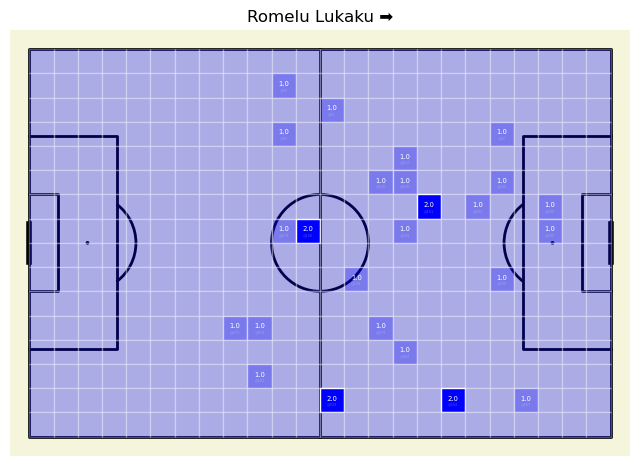

In [89]:
player_data = stats_df.iloc[10].Player
test_action_list = player_stats[player_data]["Pass"]["locations"]
Draw_Pitch_Actions(test_action_list, False, "data/location_df.csv", player_data).plot().save_fig("plots_imgs/player.png")

In [95]:
# x_data["players_df"][["Name","Club","Playing_Position","Pos_Rank_Average"]]
# x_data["match_data"], y_data["match_data"]

In [92]:
stats_df

,Player,Pass_Total,Shot_Total,Dribble_Total
0,André Onana,29,0,0
1,Alessandro Bastoni,62,1,4
2,Milan Škriniar,49,1,0
3,Federico Dimarco,54,2,1
4,Nicolò Barella,43,0,0
5,Marcelo Brozović,60,2,1
6,Hakan Çalhanoğlu,58,2,1
7,Denzel Dumfries,42,0,1
8,Henrikh Mkhitaryan,50,4,4
9,Valentín Carboni,34,1,2


In [96]:
predicted_df.query(f"Club=='{Club_x_NAME}'")[["Name"]]

,Name
923,Romelu Lukaku
924,Lautaro Martínez
925,Nicolò Barella
926,Milan Škriniar
927,Marcelo Brozović
...,...
989,Kristian Dervishi
990,Kevin Maussi Martins
991,Marco Baldelli
992,Filippo De Milato


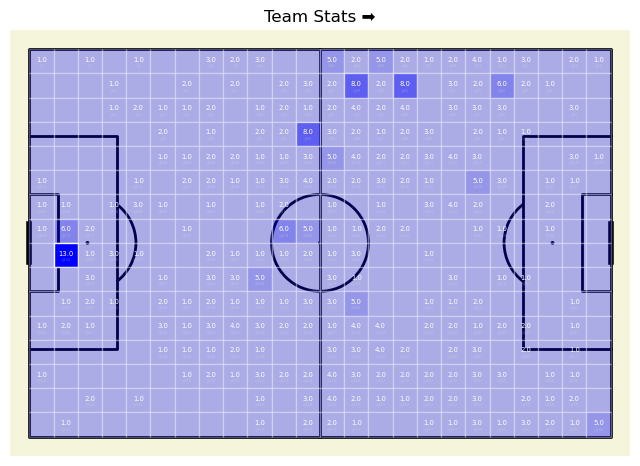

In [94]:
Draw_Pitch_Actions(x_data["pass_map"], False, "data/location_df.csv", "Team Stats").plot().save_fig("plots_imgs/volumer.png")

In [53]:
x_data["team_probs"][["Name","pass_weight_prob","shot_weight_prob","dribble_weight_prob"]]

,Name,pass_weight_prob,shot_weight_prob,dribble_weight_prob
281,Thibaut Courtois,0.059223,0.000000,0.000000
288,Dani Carvajal,0.111076,0.049406,0.054583
293,Éder Militão,0.105424,0.065083,0.058187
291,Antonio Rüdiger,0.105221,0.075059,0.027806
286,David Alaba,0.106424,0.084086,0.052523
279,Luka Modrić,0.110218,0.084086,0.113800
283,Toni Kroos,0.109577,0.087886,0.049434
285,Federico Valverde,0.089358,0.113539,0.098867
292,Marco Asensio,0.080192,0.134917,0.167353
280,Karim Benzema,0.067639,0.160095,0.152420


<br><br><br><br><br><br><br><br>
<h2 style="color:white;background:gray;"> _***Triple_Prob_Dict</h2>

In [54]:
pass_df = pd.read_csv("../match_logs/Big5@22-23@passing.csv")[["Att","Club"]].groupby(by="Club").mean().reset_index().sort_values("Att", ascending=False)
shot_df = pd.read_csv("../match_logs/Big5@22-23@shooting.csv")[["Sh","Club"]].groupby(by="Club").mean().reset_index().sort_values("Sh", ascending=False)
dribble_df = pd.read_csv("../match_logs/Big5@22-23@possession.csv")[["Att","Club"]].groupby(by="Club").mean().reset_index().sort_values("Att", ascending=False)
merged_df = pd.merge(
    pass_df.merge(shot_df, on="Club", suffixes=("", "_shot")),
    dribble_df, on="Club", suffixes=("_pass", "_dribble")
)
merged_df.rename(columns={"Sh":"Att_shot"}, inplace=True)
action_columns = merged_df.select_dtypes(exclude="object").columns
merged_df["Total_touches"] = merged_df.apply(lambda row: row[action_columns].sum(), axis=1)
merged_df["%pass"] = merged_df["Att_pass"] / merged_df["Total_touches"]
merged_df["%shot"] = merged_df["Att_shot"] / merged_df["Total_touches"]
merged_df["%dribble"] = merged_df["Att_dribble"] /  merged_df["Total_touches"]
merged_df["Triple_Prob_Dict"] = merged_df.apply(lambda row: {
    "Pass": (row["Att_pass"]/row["Total_touches"]),
    "Shot": row["Att_shot"]/row["Total_touches"],
    "Dribble": row["Att_dribble"]/row["Total_touches"],
}, axis=1)
# merged_df.to_csv("../match_logs/Big5@22-23@triple_stats.csv", index=False)